# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Initialization</h1></span>
This notebook is forked from [here](https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only)

Credit:
* https://www.kaggle.com/code/samu2505/isic-pytorchmodel-training
    * This notebook added images from past ISIC datasets and I used it to enlarge the size of positive cases
    
Future Improvements:
* I used EffNet_b2, and maybe other model could have better performance.
* The size of dataset is limited due to the computation power. if you have better machine, you could enlarge the dataset of training.
* Parameter finetuning (the epoch = 20 now).
* I only one fold out of five, which can be changed.

Notebooks:
- Training notebook (This Notebook)
- [Inference notebook](https://www.kaggle.com/code/hugowjd/isic-2024-pytorch-inference-effnet-b2/)

Updates:
* Version 1-7: Test from EffNet_b0 to EffNet_b3
* Version 8-10: Enable multiple folds training

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 50px 50px;">Import Required Libraries</h1></span>

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00a 0:00:01m


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from pathlib import Path

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
# from colorama import Fore, Back, Style
# b_ = Fore.BLUE
# sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Plot package
import PIL
from matplotlib import pyplot as plt

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Configuration</h1></span>

In [28]:
CONFIG = {
    "seed": 22,
    "epochs": 15,
    "img_size": 384,
    "model_name": "tf_efficientnet_b3_ns",
    # "model_name": "densenet121.tv_in1k",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b3/1/tf_efficientnet_b3_aa-84b4657e.pth",
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [29]:
CONFIG['device']

device(type='cuda', index=0)

## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 50px 50px;">Set Seed for Reproducibility</h2></span>

In [30]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeding done ...")

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
set_seed(CONFIG['seed'])

Seeding done ...


In [31]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [32]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data</h1>

In [33]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [34]:
# Read past isic competition data
check_path = lambda p: os.path.exists(p)

# 2020
DATA_PATH_2020 = Path("/kaggle/input/isic-2020-jpg-256x256-resized")
get_image_path_2020 = lambda p: os.path.join(f'{str(DATA_PATH_2020/"train-image/image")}/{p}.jpg')
df_train_2020 = pd.read_csv(DATA_PATH_2020/"train-metadata.csv")
df_positive_2020 = df_train_2020[df_train_2020["target"] == 1].reset_index(drop=True)
df_positive_2020['file_path'] = df_positive_2020["isic_id"].apply(get_image_path_2020)
df_positive_2020['exists'] = df_positive_2020['file_path'].apply(check_path)
df_positive_2020 = df_positive_2020[df_positive_2020['exists'] == True].reset_index()
# 2019
DATA_PATH_2019 = Path("/kaggle/input/isic-2019-jpg-256x256-resized")
get_image_path_2019 = lambda p: os.path.join(f'{str(DATA_PATH_2019/"train-image/image")}/{p}.jpg')
df_train_2019 = pd.read_csv(DATA_PATH_2019/"train-metadata.csv")
df_positive_2019 = df_train_2019[df_train_2019["target"] == 1].reset_index(drop=True)
df_positive_2019['file_path'] = df_positive_2019["isic_id"].apply(get_image_path_2019)
df_positive_2019['exists'] = df_positive_2019['file_path'].apply(check_path)
df_positive_2019 = df_positive_2019[df_positive_2019['exists'] == True].reset_index()
# 2018
DATA_PATH_2018 = Path("/kaggle/input/isic-2018-jpg-256x256-resized")
get_image_path_2018 = lambda p: os.path.join(f'{str(DATA_PATH_2018/"train-image/image")}/{p}.jpg')
df_train_2018 = pd.read_csv(DATA_PATH_2018/"train-metadata.csv")
df_positive_2018 = df_train_2018[df_train_2018["target"] == 1].reset_index(drop=True)
df_positive_2018['file_path'] = df_positive_2018["isic_id"].apply(get_image_path_2018)
df_positive_2018['exists'] = df_positive_2018['file_path'].apply(check_path)
df_positive_2018 = df_positive_2018[df_positive_2018['exists'] == True].reset_index()

In [35]:
past_df_positive = pd.concat([df_positive_2018, df_positive_2019, df_positive_2020], axis=0)
past_df_positive.head(3)
print(f'Number of positive cases: {past_df_positive.shape[0]}')

Number of positive cases: 5768


In [36]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print("        df.size, # of positive cases")
print("original>", df.shape[0], df.target.sum())
df_2024 = df.copy()
selected_cols = ['isic_id', 'target', 'file_path', 'patient_id']
# Positive cases
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_positive['file_path'] = df_positive['isic_id'].apply(get_train_file_path)
df_positive = pd.concat([df_positive[selected_cols], past_df_positive[selected_cols]], axis = 0).reset_index(drop=True)
# Negative cases
df_negative = df[df["target"] == 0].reset_index(drop=True)
df_negative = df_negative.iloc[:df_positive.shape[0]*2, :] # positive:negative = 1:5
df_negative['file_path'] = df_negative['isic_id'].apply(get_train_file_path)
df_negative = df_negative[selected_cols]
df_negative = df_negative[ df_negative["file_path"].isin(train_images) ]
df = pd.concat([df_positive, df_negative]).reset_index(drop=True)
print("filtered>", df.shape[0], df.target.sum())

df.head(3)

        df.size, # of positive cases
original> 401059 393
filtered> 1179 393


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...


In [37]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

58

## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 10px 10px;">Display Images</h2></span>

Positive Cases



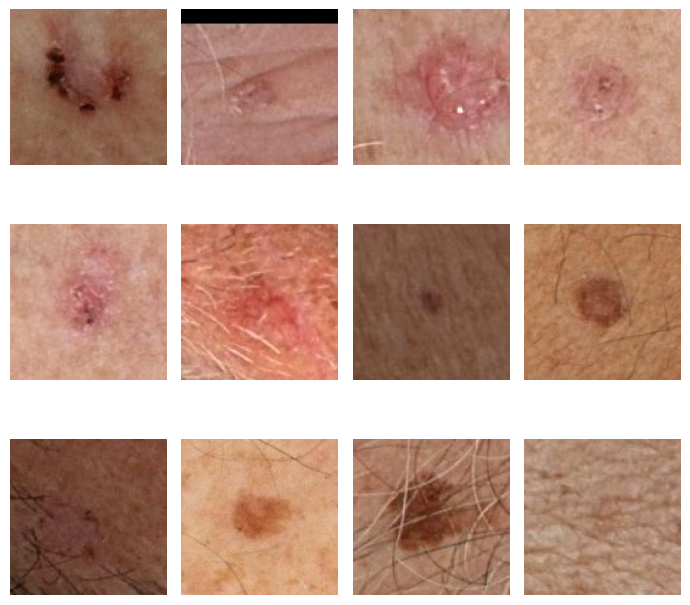


Negative Cases



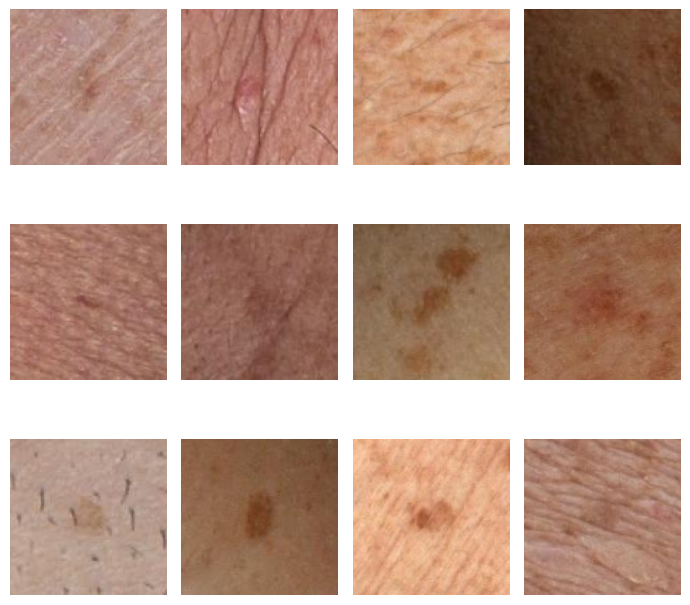

In [38]:
# Display 12 positive images and 12 negative images
fig, axes = plt.subplots(3, 4, figsize=(7,7))
axes = axes.flatten()
print("Positive Cases\n")
for i in range(12):
    path = df_positive.loc[i, 'file_path']
    img = PIL.Image.open(path).convert("RGB")
    axes[i].imshow(img)
    axes[i].axis(False)
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(3, 4, figsize=(7,7))
axes = axes.flatten()
print("\nNegative Cases\n")
for i in range(12):
    path = df_negative.loc[i, 'file_path']
    img = PIL.Image.open(path).convert("RGB")
    axes[i].imshow(img)
    axes[i].axis(False)    
plt.tight_layout()
plt.show()

## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 10px 10px;">Target Plot</h2></span>

I added positive cases from past data to enlarge the positive cases size.

<Axes: title={'center': 'Data combined past positive cases'}, xlabel='target'>

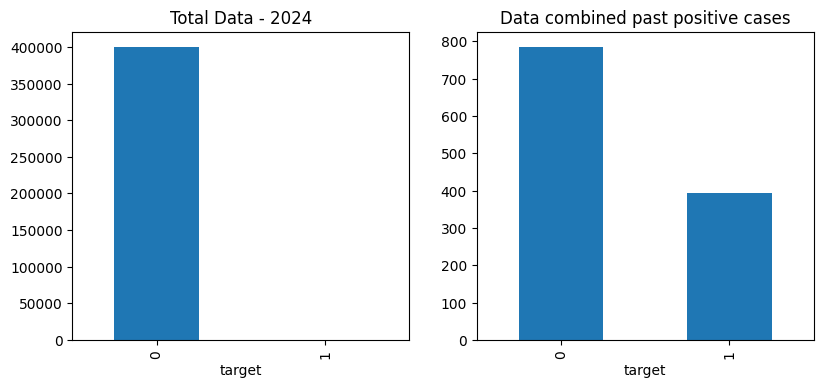

In [39]:
plt.subplot(141)
plt.title("Total Data - 2024")
df_2024['target'].value_counts().plot(kind='bar', figsize=(20,4))
plt.subplot(142)
plt.title("Data combined past positive cases")
df['target'].value_counts().plot(kind='bar', figsize=(20,4))

## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 10px 10px;">Create Folds</h2></span>

In [40]:
sgkf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle = True, random_state=42) # I don't why my SGKF doesn't work without patient_id
from sklearn.model_selection import KFold
# kf = KFold(CONFIG['n_fold'], shuffle=True, random_state=222)
for fold, ( _, val_) in enumerate(sgkf.split(df, df['target'])):
    df.loc[val_ , "kfold"] = int(fold)

In [41]:
df.head(10)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path,kfold
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...,0.0
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...,3.0
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...,3.0
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...,0.0
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...,4.0
5,ISIC_0190307,1,IP_4890448,65.0,male,head/neck,6.10,TBP tile: close-up,3D: XP,36.467641,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,95.272583,/kaggle/input/isic-2024-challenge/train-image/...,2.0
6,ISIC_0211092,1,IP_2203964,65.0,male,posterior torso,2.52,TBP tile: close-up,3D: white,18.735590,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,99.999869,/kaggle/input/isic-2024-challenge/train-image/...,0.0
7,ISIC_0220459,1,IP_7346729,65.0,male,upper extremity,5.54,TBP tile: close-up,3D: XP,19.577950,...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,NaN,NaN,NaN,NaN,99.999020,/kaggle/input/isic-2024-challenge/train-image/...,2.0
8,ISIC_0238218,1,IP_6356898,55.0,male,head/neck,1.45,TBP tile: close-up,3D: XP,16.645950,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.914940,/kaggle/input/isic-2024-challenge/train-image/...,1.0
9,ISIC_0275647,1,IP_7411721,45.0,male,posterior torso,5.62,TBP tile: close-up,3D: XP,23.281400,...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,NaN,NaN,NaN,NaN,100.000000,/kaggle/input/isic-2024-challenge/train-image/...,1.0


## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 10px 10px;">Dataset Class</h2></span>

In [42]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 4
    
    def __getitem__(self, index):
        if random.random() <= 0.25:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 20px 20px">Augmentations</h2></span>

In [43]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.3),
        A.Flip(p=0.2),
        A.Downscale(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>
## <span><h2 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px">GeM Pooling</h2></span>

In [44]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [45]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        # self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output



# <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px;">Loss Function</h1></span>

In [46]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

# <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 20px 20px">Training Function</h1></span>

In [47]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 20px 20px">Validation Function</h1></span>

In [48]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:  
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])   
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training</h1></span>

In [49]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    best_valid_loss = np.inf
    history = defaultdict(list)
    best_loss_epoch = 0
    best_auroc_epoch = 0
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        if val_epoch_loss <= best_valid_loss:
            print(f"Validation Loss Improved ({best_valid_loss} ---> {val_epoch_loss})")
            best_valid_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_VAL_LOSS_model_{fold}.bin"
            torch.save(model.state_dict(), PATH)
            best_loss_epoch = epoch
            # Save a model file from the current directory
            print(f"Model Saved")
        
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_AUROC_model_{fold}.bin"
            torch.save(model.state_dict(), PATH)
            best_auroc_epoch = epoch
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    PATH = f"Final_model_{fold}.bin"
    torch.save(model.state_dict(), PATH)
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}, on Epoch {:.0f}".format(best_epoch_auroc, best_auroc_epoch))
    print("Best Loss: {:.4f}, on Epoch {:.0f}".format(best_valid_loss, best_loss_epoch))
    print()
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [50]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [51]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
#     train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    train_dataset = ISICDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 20px 20px">Start Training</h1></span>

In [52]:
for fold in range(5):
    print(f'Fold - {fold}')
    torch.cuda.empty_cache()
    model = ISICModel(CONFIG['model_name'], checkpoint_path=CONFIG['checkpoint_path'])
    model.to(CONFIG['device']);
    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    train_loader, valid_loader = prepare_loaders(df, fold=fold)
    print(f'Train size - {len(train_loader)}, Valid size - {len(valid_loader)}')
    model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'], fold = fold)


Fold - 0
Train size - 58, Valid size - 4
[INFO] Using GPU: Tesla T4



100%|██████████| 4/4 [00:06<00:00,  1.69s/it, Epoch=1, LR=5e-7, Valid_Auroc=0.532, Valid_Loss=0.577]


Validation Loss Improved (inf ---> 0.5767196214805215)
Model Saved
Validation AUROC Improved (-inf ---> 0.5315461777931512)
Model Saved

Training complete in 0h 0m 37s
Best AUROC: 0.5315, on Epoch 1
Best Loss: 0.5767, on Epoch 1
Fold - 1
Train size - 58, Valid size - 4
[INFO] Using GPU: Tesla T4



 83%|████████▎ | 48/58 [00:24<00:05,  1.93it/s, Epoch=1, LR=4.04e-6, Train_Auroc=0.65, Train_Loss=0.613] 


KeyboardInterrupt: 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

Only Display log of last fold training

In [ ]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()